In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy

from s4hci.utils.data_handling import load_adi_data, save_as_fits

# Load the dataset

In [2]:
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_304_199_C-0065_C_.hdf5"

In [3]:
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=dataset_hdf5_file,
        data_tag="object",
        psf_template_tag="psf_template",
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

## stack the data to run a CPU based PCA

In [4]:
num_frames = science_data.shape[0]
stacking_n_frames = 10

In [5]:
stacking_idx = np.array_split(np.arange(num_frames), 
                              int(num_frames / stacking_n_frames))

In [6]:
stacked_science = np.array([np.mean(science_data[tmp_idx], axis=0) for tmp_idx in stacking_idx])
stacked_angles = np.array([np.median(raw_angles[tmp_idx], axis=0) for tmp_idx in stacking_idx])

In [7]:
stacked_science.shape

(5756, 117, 117)

In [8]:
stacked_angles.shape

(5756,)

# Run a CPU based PCA with PynPoint / sklearn

In [9]:
from pynpoint.util.psf import pca_psf_subtraction
from sklearn.decomposition import PCA
from s4hci.utils.adi_tools import combine_residual_stack

In [10]:
_, residual_stack = pca_psf_subtraction(
    images=stacked_science,
    angles=-np.rad2deg(stacked_angles),
    pca_number=50)

pynpoint_residual = np.mean(residual_stack, axis=0)

In [11]:
# the same but with sklearn
pca_model = PCA(n_components=50)

im_shape = stacked_science.shape
im_reshape = stacked_science.reshape(im_shape[0], im_shape[1]*im_shape[2])
im_reshape -= np.mean(im_reshape, axis=0)

pca_model.fit(im_reshape)
pca_rep = np.matmul(im_reshape, pca_model.components_[:50].T)
noise_estimate = np.matmul(pca_rep, pca_model.components_[:50])
residual = im_reshape - noise_estimate

In [13]:
residual_sequence = residual.reshape(im_shape[0], im_shape[1], im_shape[2])
residual_sklearn = combine_residual_stack(
    residual_sequence, 
    angles=stacked_angles,
    combine="mean")

# PCA with torch

In [14]:
import torch

In [15]:
#%%timeit
im_shape = stacked_science.shape
data_torch = torch.from_numpy(stacked_science).to(0)

im_reshape = data_torch.view(im_shape[0], im_shape[1]*im_shape[2])
im_reshape -= torch.mean(im_reshape, axis=0)

#_, _, V = torch.pca_lowrank(torch.from_numpy(im_reshape), q=50, center=False)
_, _, V = torch.svd_lowrank(im_reshape, niter=1, q=5000)
#_, _, V = torch.svd(im_reshape)

pca_rep = torch.matmul(im_reshape, V[:, :50])
noise_estimate = torch.matmul(pca_rep, V[:, :50].T)
residual = im_reshape - noise_estimate
residual_sequence = residual.view(im_shape[0], im_shape[1], im_shape[2])

In [16]:
residual_torch = combine_residual_stack(
    residual_sequence.cpu().numpy(), 
    angles=stacked_angles,
    combine="mean")

# Compare the output

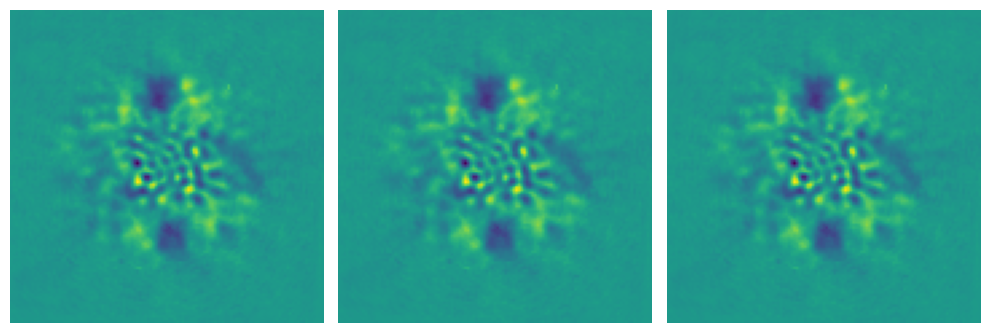

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.imshow(residual_sklearn)
ax2.imshow(pynpoint_residual)
ax3.imshow(residual_torch)
ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
plt.tight_layout()

# combine residuals with rotation grid

In [18]:
from s4hci.models.rotation import FieldRotationModel

In [19]:
rotation_model = FieldRotationModel(
    all_angles=stacked_angles,
    input_size=science_data.shape[1],
    subsample=1,
    inverse=False,
    register_grid=True)

In [20]:
rotation_model = rotation_model.to(0)

In [21]:
rotated_frames = rotation_model(
    residual_sequence.unsqueeze(1).float(),
    parang_idx=torch.arange(len(residual_sequence))).squeeze(1)

residual_torch_rot = torch.mean(rotated_frames, axis=0).cpu().numpy()

In [22]:
residual_torch_rot = torch.mean(rotated_frames, axis=0).cpu().numpy()

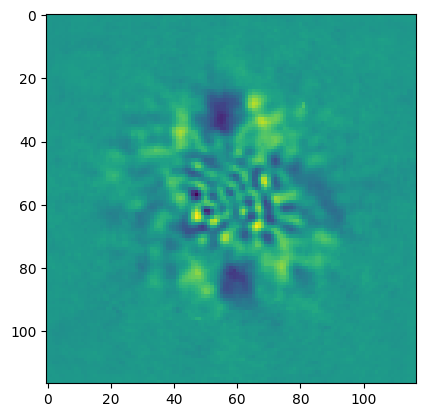

In [23]:
plt.imshow(residual_torch_rot)

# Test the pca function

In [24]:
from tqdm import tqdm

In [25]:
import numpy as np
import torch

from s4hci.models.rotation import FieldRotationModel


def pca_psf_subtraction_gpu(
        images: np.ndarray,
        angles: np.ndarray,
        pca_numbers: np.ndarray,
        device: torch.device,
        approx_svd: int,
        subsample_rotation_grid: int = 1,
        ) -> np.ndarray:

    # 1.) Convert images to torch tensor
    im_shape = images.shape
    images_torch = torch.from_numpy(images).to(device)

    # 2.) remove the mean as needed for PCA
    images_torch = images_torch - images_torch.mean(dim=0)

    # 3.) reshape images to fit for PCA
    images_torch = images_torch.view(im_shape[0], im_shape[1] * im_shape[2])

    # 4.) compute PCA basis
    _, _, V = torch.svd_lowrank(images_torch, niter=1, q=approx_svd)

    # 5.) build rotation model
    rotation_model = FieldRotationModel(
        all_angles=angles,
        input_size=im_shape[1],
        subsample=subsample_rotation_grid,
        inverse=False,
        register_grid=True)
    rotation_model = rotation_model.to(device)

    # 6.) compute PCA residuals for all given PCA numbers
    pca_residuals = []
    for pca_number in tqdm(pca_numbers):
        
        pca_rep = torch.matmul(images_torch, V[:, :pca_number])
        noise_estimate = torch.matmul(pca_rep, V[:, :pca_number].T)
        residual = images_torch - noise_estimate
        residual_sequence = residual.view(im_shape[0], im_shape[1], im_shape[2])

        rotated_frames = rotation_model(
            residual_sequence.unsqueeze(1).float(),
            parang_idx=torch.arange(len(residual_sequence))).squeeze(1)

        residual_torch_rot = torch.mean(rotated_frames, axis=0).cpu().numpy()
        pca_residuals.append(residual_torch_rot)
        
    return np.array(pca_residuals)

In [29]:
pca_residuals = pca_psf_subtraction_gpu(
    images=science_data,
    angles=raw_angles,
    pca_numbers=np.arange(1, 500),
    device=0,
    approx_svd=10000,
    subsample_rotation_grid=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:44<00:00, 11.13it/s]


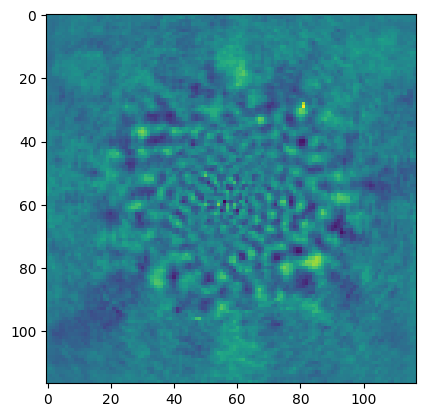

In [30]:
plt.imshow(pca_residuals[300])

In [31]:
save_as_fits(pca_residuals, "PCA_residuals_torch.fits")

In [39]:
len(np.concatenate([np.arange(1, 100, 2), np.arange(100, 505, 5)]))

131